In [2]:
from typing import List

import os
import sys

ROOT_DIR = os.path.dirname(os.getcwd())
sys.path.append(ROOT_DIR)

import pandas as pd
from utils import *

In [16]:
import itertools

class MinHashDeduplicator:
    '''
    A class to deduplicate articles using MinHash
    '''
    def __init__(self, k=8, threshold=0.51):
        self.k = k
        self.treshold = threshold
        self.metrics = []

    def predict(self, articles: pd.DataFrame) -> List[int]:
        # change each row to set without hashed values, without NaNs
        metrics = []
        rows = []
        for _, row in articles.iterrows():
            row = row.dropna().apply(hash).to_list()
            row.sort()
            rows.append(set(row[:self.k]))

        result = [0 for _ in rows]
        # for each pair of rows calculate estimate
        for (i, j) in itertools.combinations(range(len(result)), 2):
            X = set(sorted(rows[i] | rows[j])[:self.k])
            Y = X & rows[i] & rows[j]
            self.metrics.append(len(Y) / self.k)
            if len(Y) / self.k > self.treshold:
                result[i] = 1
                result[j] = 1
        return result


In [4]:
df = prepare_dataset()

Loading datasets: 100%|██████████| 5/5 [00:06<00:00,  1.26s/it]


In [ ]:
deduplicator = MinHashDeduplicator(threshold=0.99)
benchmark = Benchmark(deduplicator)

print(f"{dataset}: {benchmark.evaluate(df.drop(columns=['caption', 'label', 'database', 'source-app']), df['label'])}")

<module 'utils.dataset' from '/home/stachu/projects/dupli-gone/utils/dataset.py'>: {'accuracy': 0.5015141682889898, 'precision': 1.0, 'recall': 0.003028336577979463, 'f1': 0.00603838688807378, 'prediction_time_sec': 91.78468060493469, 'samples': 9347, 'duplicates': 4623}


In [11]:
print(len(deduplicator.metrics))

import random

metrics = random.sample(deduplicator.metrics, 10000)


43678531


(array([9.354e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 6.250e+02, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.900e+01, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

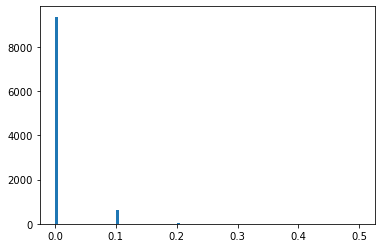

In [13]:
import matplotlib.pyplot as plt

plt.hist(metrics, bins=100)

In [43]:
def find_ngrams(text: str, n: int):
    return [text[i:i + n] for i in range(len(text) - n + 1)]

def jaccard_similarity(a: str, b: str) -> float:
    a_ngrams = set(find_ngrams(a, 2))
    b_ngrams = set(find_ngrams(b, 2))

    intersection = a_ngrams.intersection(b_ngrams)
    union = a_ngrams.union(b_ngrams)

    return len(intersection) / len(union) if len(union) != 0 else 0

def compare_records(rec1: List[str], rec2: List[str]):
    scores = [jaccard_similarity(a, b) for a, b in zip(rec1, rec2) if not pd.isna(a) and not pd.isna(b)]
    return np.mean(scores)

def extract_interesting_strings(series: pd.Series) -> List[str]:
    return series[["titles", "contributors", "periodical", "abstract"]].tolist()

def deduplication_results(df: pd.DataFrame, threshold: float = 0.6) -> List[bool]:
    labels = {idx: 0 for idx in df.index}
    for (s1_idx, s1), (s2_idx, s2) in itertools.combinations(df.iterrows(), 2):
        score = compare_records(
            extract_interesting_strings(s1),
            extract_interesting_strings(s2)
        )
        
        if score > threshold:
            labels[s1_idx] = 1
            labels[s2_idx] = 1
    return [value for key, value in sorted(labels.items())]